# Exploratory Analysis using Data from Sylvia Beach's bookstore

In [136]:
from IPython.display import Image
Image(url= "https://www.nybooks.com/wp-content/uploads/2019/11/beach-lead.jpg", width=700)

-------

## Cultural Context
In the aftermath of World War I, emigrant Sylvia Beach opened an American bookstore in Paris that would in its course change Modernist literature culture fundamentally. Sylvia Beach was one of many expatriates in Paris when the city became the hotbed of art, cinema, literature, and music.1 Her bookstore, which also functioned as a lending library, quickly established itself as a meeting point for the Lost Generation and other avant garde movements.2 It was at this address that expatriate writers such as Ernest Hemingway, F. Scott Fitzgerald, and James Joyce met, exchanged ideas, and influenced each other’s work.
## Source Documents
The datasets used in this notebook derive from Princeton's "Shakespeare and Company Project" (https://shakespeareandco.princeton.edu/about/data/). The project's aim is to digitally recreate the cultural and intellectual landscape of interwar Paris, using documents from Princeton's collection Sylvia Beach Papers. The project itself focuses on Beach's bookkeeping and business documents, such as lending library cards, logbooks, and address books.
## Datasets
The project resulted in three datasets (in CSV format): members, books, and events.

Members: The members dataset records the members of the lending library cards. It includes information about 5,235 lending library members in the following fields: member URL, member name, sort name, title, gender, individual or organization, has lending library card, birth year, death year, membership years, VIAF URL, Wikipedia URL, nationalities, addresses, postal codes, arrondissements, longitude and latitude coordinates, notes, last updated.

Books: The books dataset records the books available to purchase and/or borrow at the lending library. It includes information about 6,020 books and other items in the following fields: book URL, title, author, editor, contributor, translator, illustrator, introduction, preface, photographer, year of publication, format, uncertain, eBook URL, volume/issue, notes, event count, borrow count, purchase count, circulation years, last updated.

Events: The events dataset brings the previous two datasets together by recording events. Such events include borrows, purchases, subscriptions (to the library), renewal of subscriptions, gifts, payments of deposit, and other processes inherent to libraries. It includes information about 35,523 lending library events in the following fields: event type, start date, end date, member URL, member name, sort name, subscription price, deposit amount, duration, duration in days, volume limit, category, purchase date, reimbursement amount, book borrow status, borrow duration in days, book purchase price, currency, item URL, title, volume, author, year of publication, notes, source type, source citation, source manifest, source image.

More information on the datasets can be accessed at https://shakespeareandco.princeton.edu/about/data/

More information on the topic and my corresponding master's thesis can be viewed in the following document: misc\dittmann_expose.pdf

---------

## Analysis

In [137]:
import matplotlib.pyplot as plt # Plotting and visualizing data
import seaborn as sns # Improved plotting and visualizing data
import pandas as pd # Data analysis and manipulation
import numpy as np # Arrays and matrices
from matplotlib_venn import venn2 # Venn diagrams
from scipy.stats import entropy # Entropy calculation
import networkx as nx # Network visualizations
# from networkx.algorithms.community import girvan_newman
import geopandas as gpd # Pandas library for geo information

Reading in the datasets..

In [138]:
books = pd.read_csv('../data/SCoData_books_v1.2_2022_01.csv', encoding='utf-8')
members = pd.read_csv('../data/SCoData_members_v1.2_2022_01.csv', encoding='utf-8')
events = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8')

C:\Users\dittm\AppData\Local\Temp\ipykernel_20476\3882839150.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv('../data/SCoData_events_v1.2_2022_01.csv', encoding='utf-8')


In [139]:
books.columns

Index(['uri', 'title', 'author', 'editor', 'translator', 'introduction',
       'illustrator', 'photographer', 'year', 'format', 'uncertain',
       'ebook_url', 'volumes_issues', 'notes', 'event_count', 'borrow_count',
       'purchase_count', 'circulation_years', 'updated'],
      dtype='object')

In [140]:
members.columns

Index(['uri', 'name', 'sort_name', 'title', 'gender', 'is_organization',
       'has_card', 'birth_year', 'death_year', 'membership_years', 'viaf_url',
       'wikipedia_url', 'nationalities', 'addresses', 'postal_codes',
       'arrondissements', 'coordinates', 'notes', 'updated'],
      dtype='object')

### Unique Authors

In [141]:
# Filter books of format 'Book', select relevant columns, and drop rows with any missing values
book_authors = books[(books['format'] == 'Book')][['author']].dropna()

# Remove duplicate entries to ensure all authors are unique across the dataset.
# Here we consider only the 'author' column for uniqueness.
unique_authors = book_authors.drop_duplicates(subset=['author'])

unique_authors.shape

(1995, 1)

#### Quick check

In [142]:
unique_authors.loc[unique_authors['author'] == 'Hemingway, Ernest']

,author
2140,"Hemingway, Ernest"


### Unique Members

In [143]:
member_filtered = members[['sort_name']].dropna()

unique_members = member_filtered.drop_duplicates(subset=['sort_name'])

unique_members.shape

(4804, 1)

#### Quick check

In [144]:
unique_members.loc[unique_members['sort_name'] == 'Hemingway, Ernest']

,sort_name
2270,"Hemingway, Ernest"


### Intersection of Authors and Members

In [145]:
unique_members.rename(columns={'sort_name': 'member'}, inplace=True)

merged_df = pd.merge(unique_members, unique_authors, how='outer', left_on='member', right_on='author')

merged_df.sample(3)

C:\Users\dittm\AppData\Local\Temp\ipykernel_20476\2510572786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_members.rename(columns={'sort_name': 'member'}, inplace=True)


,member,author
4344,"Temple, Mrs.",NaN
2776,Lévy,NaN
3076,"McCormack, Jane",NaN


In [146]:
member_is_author = merged_df.dropna().reset_index(drop=True)
member_is_author = member_is_author[['member']]  # Keep the 'member' column as it now represents both member and author
member_is_author.columns = ['name']  # Rename the column

member_is_author.shape

(84, 1)

In [147]:
member_is_author.head(5)

,name
0,"Aldington, Richard"
1,"Anderson, Margaret C."
2,"Antheil, George"
3,"Aragon, Louis"
4,"Asch, Nathan"


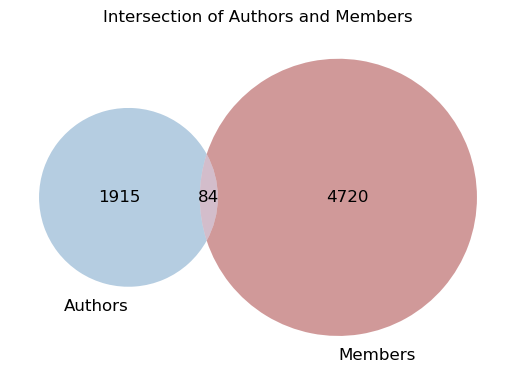

In [148]:
# Extract unique authors and members
unique_authors = set(books['author'])
unique_members = set(members['sort_name'])

# Calculate the intersection
intersection = len(unique_authors.intersection(unique_members))

# Create the Venn diagram for authors with customized colors
venn = venn2(subsets=(len(unique_authors) - intersection, len(unique_members) - intersection, intersection),
             set_labels=('Authors', 'Members'),
             set_colors=('steelblue', 'darkred'))

# Optionally, you can customize more properties, such as the transparency (alpha)
for subset in venn.subset_labels:
    if subset:  # If the subset is not None
        subset.set_fontsize(12)

plt.title('Intersection of Authors and Members')
plt.show()

matched_members = members[members['sort_name'].isin(member_is_author['name'])]

The Venn diagram shows that 84 lending library members also had works available in the lending library.

In [149]:
# Calculate the percentages
percent_intersection_authors = (intersection / len(unique_authors)) * 100
percent_intersection_members = (intersection / len(unique_members)) * 100

print(f'Percent of the intersection relative to authors: {percent_intersection_authors:.2f}%')
print(f'Percent of the intersection relative to members: {percent_intersection_members:.2f}%')

Percent of the intersection relative to authors: 4.20%
Percent of the intersection relative to members: 1.75%


### Coordinates

In [150]:
# Split the coordinates and create a new DataFrame
coordinate_list = matched_members['coordinates'].str.split(';').explode().str.strip()

# Create a DataFrame from the exploded list
coordinates_df = coordinate_list.str.split(',', expand=True)
coordinates_df.columns = ['latitude', 'longitude']

# Convert to numeric values
coordinates_df['latitude'] = pd.to_numeric(coordinates_df['latitude'])
coordinates_df['longitude'] = pd.to_numeric(coordinates_df['longitude'])

In [151]:
coordinates_df.sample(3)

,latitude,longitude
3352,48.86989,2.29764
4152,NaN,NaN
3243,48.85092,2.33845


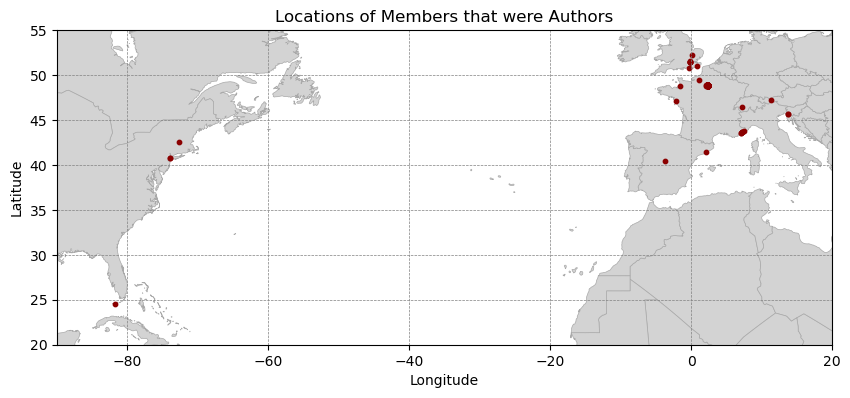

In [152]:
# Load the map of the world
world_map = gpd.read_file('../data/world.shp') # If this throws an error, try world.shx

# Create a GeoDataFrame from the coordinates
gdf = gpd.GeoDataFrame(coordinates_df, geometry=gpd.points_from_xy(coordinates_df.longitude, coordinates_df.latitude))

# Set the coordinate reference system (CRS) for your GeoDataFrame
gdf.set_crs(epsg=4326, inplace=True)  # EPSG 4326 is WGS84 latitude-longitude

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

world_map.plot(ax=ax, color='lightgray', edgecolor='darkgray', linewidth=0.5) 

gdf.plot(ax=ax, marker='o', color='darkred', markersize=10)  # Plot the scatter points

# Set limits for the axes
ax.set_xlim(-90, 20)  # Set longitude bounds
ax.set_ylim(20, 55)    # Set latitude bounds

# Here I experimented with different basemaps and then opted to not use one after all
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.NatGeoWorldMap)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.DarkMatter)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
# ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title('Locations of Members that were Authors')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)


plt.show()

world data from https://www.kaggle.com/datasets/venkatkumar001/geographical-data/data

The map shows that most members had recorded addresses in Europe, mainly England, France, Spain, Italy, Austria, and Switzerland. However, some addresses were in the United States.

### Members with the same address

In [153]:
# Split the addresses by semicolon and create a new DataFrame
addresses_df = matched_members.assign(addresses=matched_members['addresses'].str.split(';')).explode('addresses')

# Normalize and clean addresses
addresses_df['addresses'] = addresses_df['addresses'].str.strip()

# Group by addresses to find common addresses
grouped_addresses = addresses_df.groupby('addresses').agg(names=('name', ', '.join)).reset_index()

# Filter to find addresses with more than one resident
common_addresses = grouped_addresses[grouped_addresses['names'].str.contains(',')]

# Display the result
common_addresses

,addresses,names
10,"12 rue de l'Odéon, Paris","George Antheil, Sylvia Beach, Padraic Colum, R..."
46,"34 rue des Vignes, Paris","Pierre de Lanux, James Joyce"
49,"4 boulevard Raspail, Paris","Stephen Vincent Benét, Margaret Wilson"
65,"6 via Cesare Battista, Trieste","James Joyce, Stanislaus Joyce"
69,"69 rue Raynouard, Paris","Élisabeth de Gramont, Duchesse de Clermont-Ton..."
75,"71 rue du Cardinal Lemoine, Paris","James Joyce, Valery Larbaud"
99,"Hotel Jacob, 44 rue Jacob, Paris","David Gascoyne, Ernest Hemingway"
142,"Select Hôtel, 1 place de la Sorbonne, Paris","Richard Aldington, Katherine Mansfield"
149,"École normale supérieure, 45 rue d'Ulm, Paris","Samuel Beckett, Thomas MacGreevy"


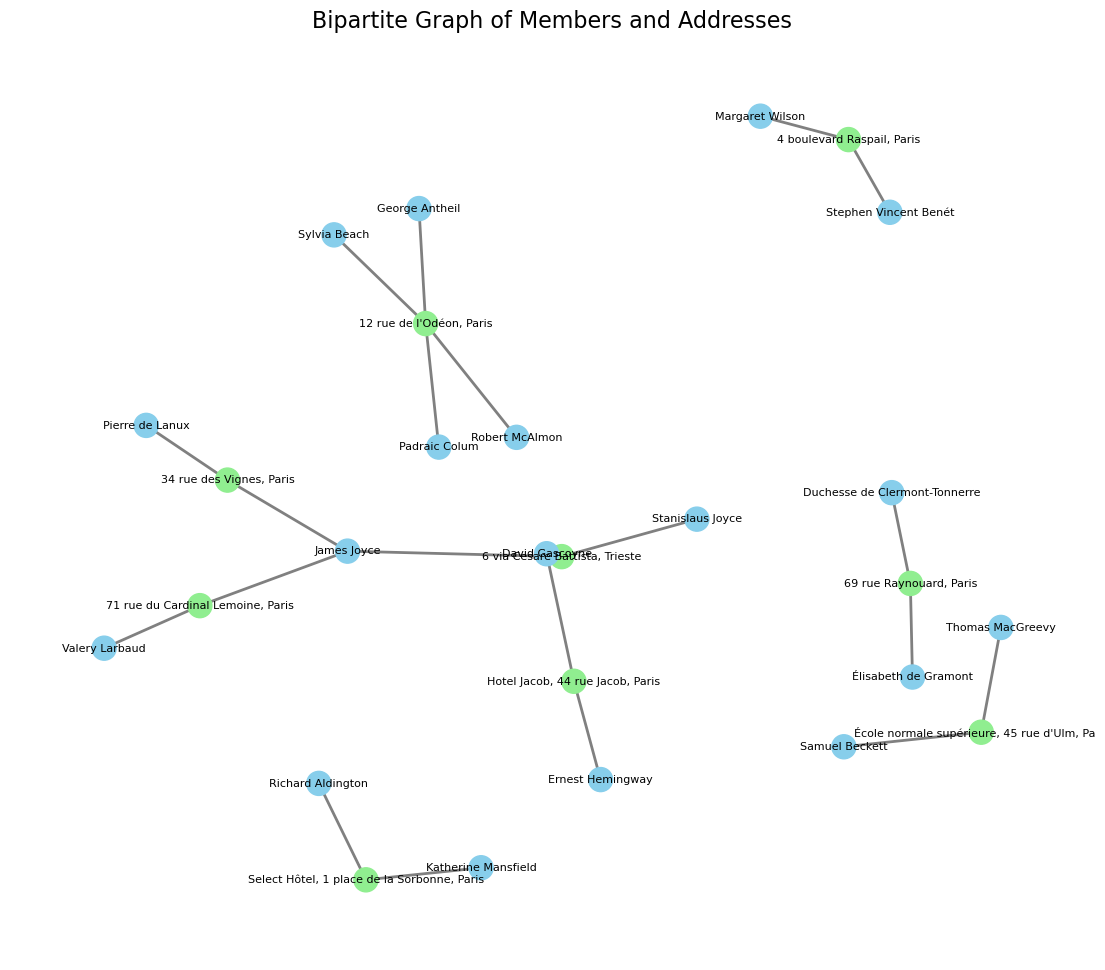

In [154]:
# Create a bipartite graph
B = nx.Graph()

# Add nodes and edges for the bipartite graph
for _, row in common_addresses.iterrows():
    address = row['addresses']
    residents = row['names'].split(', ')
    B.add_node(address, bipartite=0)  # Add address node
    for resident in residents:
        B.add_node(resident, bipartite=1)  # Add resident node
        B.add_edge(resident, address)

# Separate nodes by type for layout
people = [node for node, data in B.nodes(data=True) if data['bipartite'] == 1]
addresses = [node for node, data in B.nodes(data=True) if data['bipartite'] == 0]

# Create a bipartite layout
pos = nx.spring_layout(B, k=0.3, iterations=35)

# Draw the bipartite graph
fig, ax = plt.subplots(figsize=(14, 12))
nx.draw(B, pos, ax=ax, with_labels=True, node_size=300, 
        node_color=['skyblue' if node in people else 'lightgreen' for node in B.nodes()], 
        font_size=8, edge_color='gray', width=2)
plt.title('Bipartite Graph of Members and Addresses', size=16)
plt.show()

Interestingly enough, some members lived at the same time address at some point. The 12 rue de l'Odeon (the address of the lending library) was the most popular address, as three members lived there - four if you count Sylvia Beach herself. All addresses except for one was situated in Paris. For James Joyce there is a recorded Italian address, at which Stanislaus Joyce also lived. This is not surprising as Stanislaus was his son.

### Gender

In [155]:
count_gender = matched_members['gender'].value_counts().sort_index()

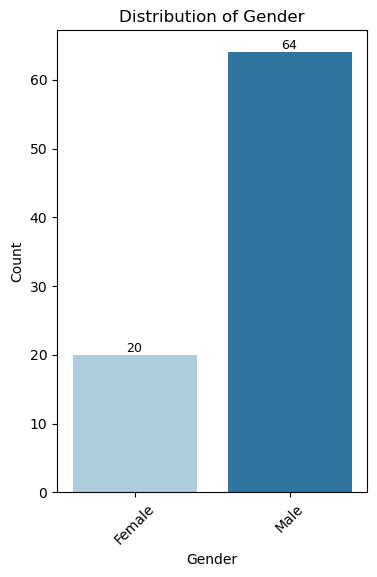

In [156]:
# Draw the graph
plt.figure(figsize=(4, 6))
ax = sns.barplot(x=count_gender.index, y=count_gender.values, palette='Paired')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, count in enumerate(count_gender.values):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=9)

plt.show()

In [157]:
percentages = matched_members['gender'].value_counts(normalize=True) * 100
print(percentages)

Male      76.190476
Female    23.809524
Name: gender, dtype: float64


Most author-members were male, but almost 1/4 were female.

#### Mode

In [158]:
mode_gender = matched_members['gender'].value_counts().idxmax() # Mode
print(f"Mode of gender distribution: {mode_gender}")

Mode of gender distribution: Male


#### Entropy

In [159]:
# Assuming `members` DataFrame and 'gender' column exist
gender_counts = matched_members['gender'].value_counts(normalize=True)
entropy_gender = entropy(gender_counts)

# Calculate the number of unique categories (genders)
num_categories = gender_counts.size

# Calculate the maximum possible entropy
max_entropy = np.log(num_categories)

# Print the entropy and the benchmark
print(f"Entropy of gender distribution: {entropy_gender}")
print(f"Maximum possible entropy with {num_categories} categories: {max_entropy}")

# Calculate the normalized entropy (entropy divided by maximum possible entropy)
normalized_entropy = entropy_gender / max_entropy

print(f"Normalized entropy: {normalized_entropy}")

Entropy of gender distribution: 0.5488743844849944
Maximum possible entropy with 2 categories: 0.6931471805599453
Normalized entropy: 0.7918583525674836


The entropy shows that the gender distribution is relatively well distributed, as the maximum entropy is only a bit higher. The normalized entropy is a good means of comparing the entropy to other datasets.

### Age

C:\Users\dittm\AppData\Local\Temp\ipykernel_20476\1030809175.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['birth_year'] = df['birth_year'].astype(int)


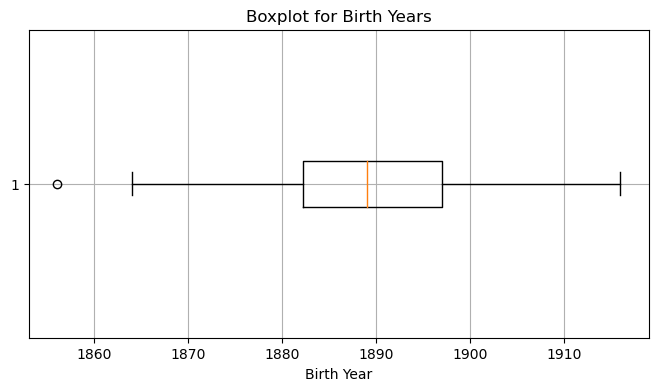

In [160]:
# Cleaning: Remove NaN values
df = matched_members.dropna(subset=['birth_year'])

# Convert birth_year to integer
df['birth_year'] = df['birth_year'].astype(int)

# Plotting a boxplot
plt.figure(figsize=(8, 4))
plt.boxplot(df['birth_year'], vert=False)  # 'vert=False' makes the boxplot horizontal
plt.title('Boxplot for Birth Years')
plt.xlabel('Birth Year')
plt.grid(True)
plt.show()

The boxplot gives great insight into the distribution of birth years. The median birth year lies around 1889. The minimum birth year (without outliers) is about 1864 and the maximum around 1916. The interquartile range is between 1883 and 1897.

#### Entropy

In [161]:
# Group birth years into bins (e.g., by decade)
matched_members['birth_year_group'] = pd.cut(matched_members['birth_year'], bins=np.arange(1850, 1920, 10))

# Calculate the normalized value counts for each bin
birth_year_group_counts = matched_members['birth_year_group'].value_counts(normalize=True)

# Calculate the entropy of the birth year distribution
entropy_birth_year = entropy(birth_year_group_counts)

# Calculate the number of unique bins
num_bins = birth_year_group_counts.size

# Calculate the maximum possible entropy
max_entropy = np.log(num_bins)

# Calculate the normalized entropy
normalized_entropy = entropy_birth_year / max_entropy

# Print the results
print(f"Entropy of birth year distribution: {entropy_birth_year}")
print(f"Maximum possible entropy with {num_bins} bins: {max_entropy}")
print(f"Normalized entropy: {normalized_entropy}")


Entropy of birth year distribution: 1.4401361309075074
Maximum possible entropy with 6 bins: 1.791759469228055
Normalized entropy: 0.803755278339878


C:\Users\dittm\AppData\Local\Temp\ipykernel_20476\827458227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_members['birth_year_group'] = pd.cut(matched_members['birth_year'], bins=np.arange(1850, 1920, 10))


In [162]:
print(matched_members['birth_year'].mean())
print(matched_members['birth_year'].median())
print(matched_members['birth_year'].mode())

1888.8658536585365
1889.0
0    1883.0
1    1888.0
2    1892.0
3    1899.0
Name: birth_year, dtype: float64


The birth year distribution seems to be multimodal as four different modes could be found.

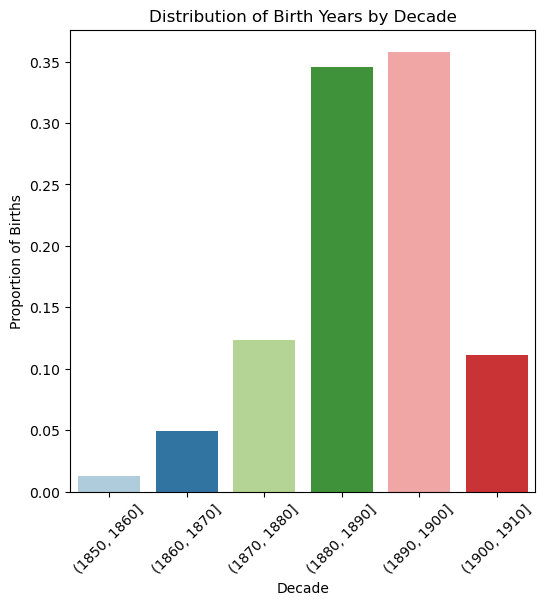

In [163]:
# Draw the Graph
plt.figure(figsize=(6, 6))
ax = sns.barplot(x=birth_year_group_counts.index, y=birth_year_group_counts.values, palette='Paired')
plt.xlabel('Decade')
plt.ylabel('Proportion of Births')
plt.title('Distribution of Birth Years by Decade')
plt.xticks(rotation=45)

plt.show()

This graph shows the distribution of birth years by decade (10 years per bin). It gives similar insight as the boxplot (1880-1900 were the most recorded birth years), but it illustrates the proportions for each decade.

Given the range of the most frequent birth years, the book publication years could be shifted around 20-30 years as many young writers sought exile in liberal Paris.

### Overall comparison of books by members

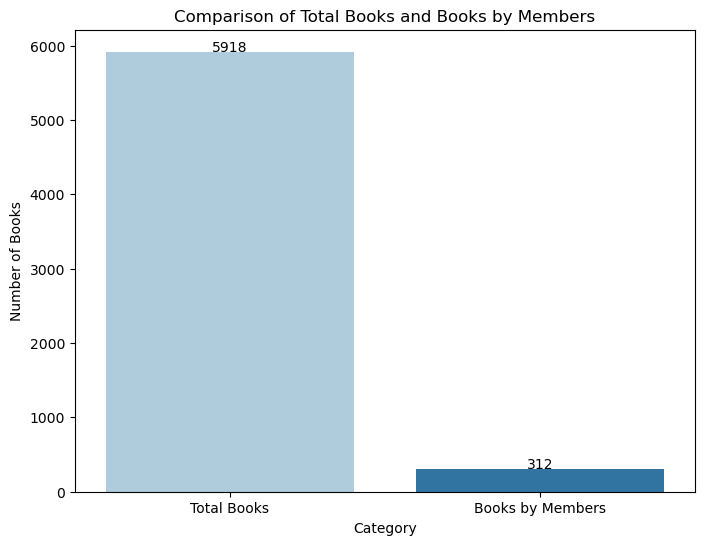

In [164]:
books_by_member = books[books['author'].isin(member_is_author['name'])]

# Calculate the number of unique titles (assuming no duplicates in the original dataset)
total_unique_titles = len(books['title'].unique())
unique_titles_by_member = len(books_by_member['title'].unique())

# Prepare data for plotting
data = pd.DataFrame({
    'Category': ['Total Books', 'Books by Members'],
    'Count': [total_unique_titles, unique_titles_by_member]
})

# Plot the diagram
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Category', y='Count', data=data, palette='Paired')
for index, row in data.iterrows():
    barplot.text(index, row.Count, round(row.Count, 2), color='black', ha="center")
plt.ylabel('Number of Books')
plt.title('Comparison of Total Books and Books by Members')
plt.show()

In [165]:
# Calculate the percentage of unique titles by members out of the total
percentage_of_books_by_members = (unique_titles_by_member / total_unique_titles) * 100

# Prepare a dictionary with the results
book_counts_summary = {
    'Total Books': total_unique_titles,
    'Books by Members': unique_titles_by_member,
    'Percentage of Books by Members': f'{percentage_of_books_by_members:.2f}%'
}

# Display the dictionary
book_counts_summary

{'Total Books': 5918,
 'Books by Members': 312,
 'Percentage of Books by Members': '5.27%'}

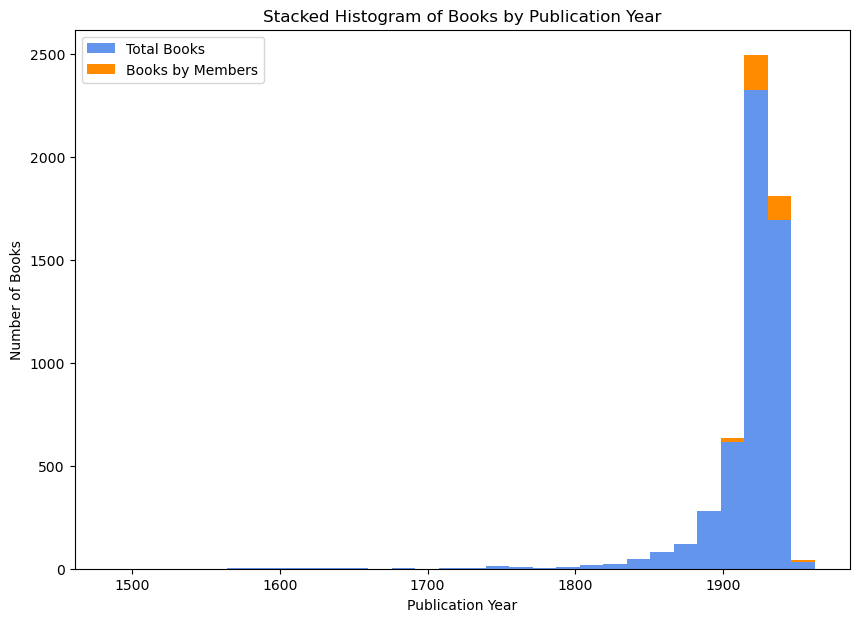

In [166]:
# Filter the books dataframe to keep only the rows where the author is in the list of authors who are members
books_by_member = books[books['author'].isin(member_is_author['name'])]

# Drop rows with missing values in the 'year' column for both datasets
books = books.dropna(subset=['year'])
books_by_member = books_by_member.dropna(subset=['year'])

# Convert 'year' to integer (or the appropriate type if not already)
books['year'] = books['year'].astype(int)
books_by_member['year'] = books_by_member['year'].astype(int)

# Prepare data for plotting
all_books = books['year']
member_books = books_by_member['year']

# Plot the stacked histogram
plt.figure(figsize=(10, 7))
plt.hist([all_books, member_books], bins=30, stacked=True, label=['Total Books', 'Books by Members'], color=['cornflowerblue', 'darkorange'])
plt.xlabel('Publication Year')
plt.ylabel('Number of Books')
plt.title('Stacked Histogram of Books by Publication Year')
plt.legend()
plt.show()

In [167]:
bin_edges = np.linspace(min(all_books.min(), member_books.min()), 1962, 31)  # Create 30 bins from min year to 1941
all_books_counts, _ = np.histogram(all_books, bins=bin_edges)
member_books_counts, _ = np.histogram(member_books, bins=bin_edges)

# Output the bin edges and counts
for i, edge in enumerate(bin_edges[:-1]):
    print(f"From {int(edge)} to {int(bin_edges[i+1])} - Total Books: {all_books_counts[i]}, Books by Members: {member_books_counts[i]}")

From 1485 to 1500 - Total Books: 1, Books by Members: 0
From 1500 to 1516 - Total Books: 1, Books by Members: 0
From 1516 to 1532 - Total Books: 0, Books by Members: 0
From 1532 to 1548 - Total Books: 0, Books by Members: 0
From 1548 to 1564 - Total Books: 1, Books by Members: 0
From 1564 to 1580 - Total Books: 2, Books by Members: 0
From 1580 to 1596 - Total Books: 4, Books by Members: 0
From 1596 to 1612 - Total Books: 3, Books by Members: 0
From 1612 to 1628 - Total Books: 2, Books by Members: 0
From 1628 to 1644 - Total Books: 2, Books by Members: 0
From 1644 to 1659 - Total Books: 3, Books by Members: 0
From 1659 to 1675 - Total Books: 1, Books by Members: 0
From 1675 to 1691 - Total Books: 2, Books by Members: 0
From 1691 to 1707 - Total Books: 1, Books by Members: 0
From 1707 to 1723 - Total Books: 5, Books by Members: 0
From 1723 to 1739 - Total Books: 4, Books by Members: 0
From 1739 to 1755 - Total Books: 12, Books by Members: 0
From 1755 to 1771 - Total Books: 9, Books by Me

As can be seen, most books by author-members were published between 1914 and 1946. When taking the birth years into consideration, this gives us an approximate idea on how old many author-members were when their works were published.

#### How many books does each author have?

In [168]:
# Group the dataframe by 'author' and count the number of titles for each author
books_count_by_author = books_by_member.groupby('author').count()['title'].sort_values(ascending=False)

# Optionally, you might want to reset the index to make the data more presentable
books_count_by_author = books_count_by_author.reset_index()
books_count_by_author.columns = ['Author', 'Number of Books']

# Display the result
print(books_count_by_author)

                      Author  Number of Books
0           Ford, Ford Madox               18
1                Pound, Ezra               16
2               Joyce, James               12
3           Bromfield, Louis               11
4            Stein, Gertrude               11
..                       ...              ...
79        Bishop, John Peale                1
80             Beach, Sylvia                1
81  Barney, Natalie Clifford                1
82            McKenney, Ruth                1
83          de Lanux, Pierre                1

[84 rows x 2 columns]


Out of all author-members, Ford Madox Ford had the most books available at the lending library, namely 18. Ezra Pound takes second place with 16 books. James Joyce, Louis Bromfield, and Gertrude Stein follow. It is notable that Ernest Hemingway does not appear in the top 5.

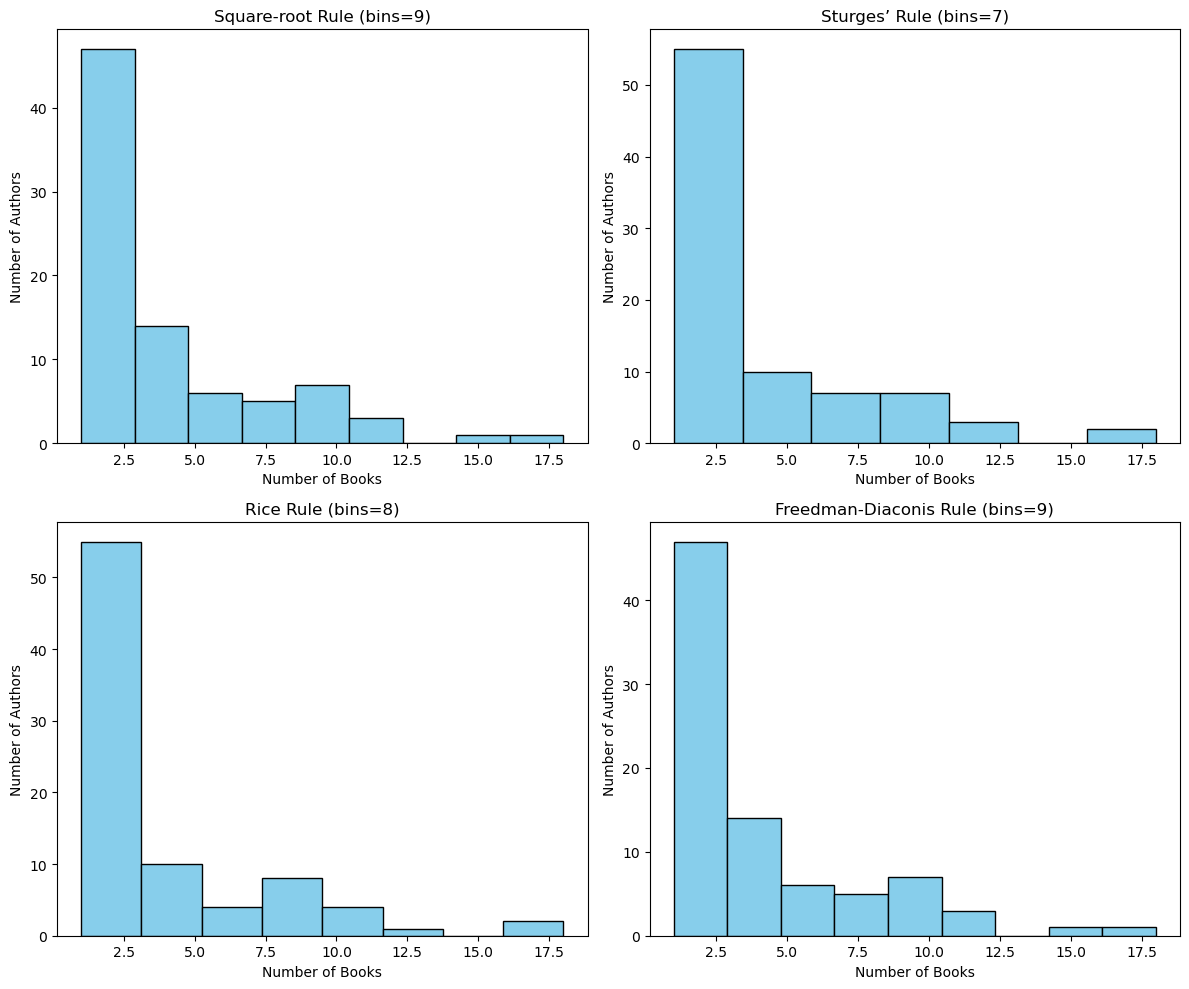

In [169]:
number_of_books = books_count_by_author['Number of Books'].values
n = len(number_of_books)

# Calculating bin numbers with different algorithms
sqrt_bins = int(np.sqrt(n))
sturges_bins = int(np.log2(n)) + 1
rice_bins = int(2 * (n ** (1/3)))
iqr = np.percentile(number_of_books, 75) - np.percentile(number_of_books, 25)
fd_bins = int(np.ptp(number_of_books) / (2 * (iqr / (n ** (1/3)))))

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

# Square-root Rule
axs[0].hist(number_of_books, bins=sqrt_bins, color='skyblue', edgecolor='black')
axs[0].set_title(f'Square-root Rule (bins={sqrt_bins})')
axs[0].set_xlabel('Number of Books')
axs[0].set_ylabel('Number of Authors')

# Sturges' Rule
axs[1].hist(number_of_books, bins=sturges_bins, color='skyblue', edgecolor='black')
axs[1].set_title(f'Sturges’ Rule (bins={sturges_bins})')
axs[1].set_xlabel('Number of Books')
axs[1].set_ylabel('Number of Authors')

# Rice Rule
axs[2].hist(number_of_books, bins=rice_bins, color='skyblue', edgecolor='black')
axs[2].set_title(f'Rice Rule (bins={rice_bins})')
axs[2].set_xlabel('Number of Books')
axs[2].set_ylabel('Number of Authors')

# Freedman-Diaconis Rule
axs[3].hist(number_of_books, bins=fd_bins, color='skyblue', edgecolor='black')
axs[3].set_title(f'Freedman-Diaconis Rule (bins={fd_bins})')
axs[3].set_xlabel('Number of Books')
axs[3].set_ylabel('Number of Authors')

plt.tight_layout()
plt.show()

This graph shows the number of author-members in relation to the numbers of books available at the lending library. I used different algorithms to calculate bin numbers. All four bin numbers show similar results: Many authors did not have more than about 3 books available in the library. The rest is more evenly distributed and dims out around 12 books. A small peak again rises around 16-18 books.

### Comparison of Borrow events


books by member

events from authors that are members

In [170]:
books_event = events[events['event_type'] == 'Borrow']
books_event.shape

(21059, 28)

In [171]:
books_event = books_event[books_event['member_sort_names'].isin(member_is_author['name'])]
books_event.shape

(877, 28)

only unique

In [172]:
books_event.member_sort_names.unique()

array(['Joyce, James', 'Hemingway, Ernest', 'Schlumberger, Jean',
       'Beach, Sylvia', 'Stein, Gertrude', 'Larbaud, Valery',
       'McAlmon, Robert', 'Wilson, Romer', 'Aragon, Louis',
       'Rodker, John', 'Wilder, Thornton', 'Pound, Ezra',
       'Mansfield, Katherine', 'Solano, Solita', 'de Lanux, Pierre',
       'Tree, Iris', 'Wickham, Anna', 'Wilson, Margaret',
       'Le Gallienne, Richard', 'Gilbert, Stuart', 'Boyd, James',
       'Flandrau, Grace', 'Porter, Katherine Anne', 'Lewisohn, Ludwig',
       'Tate, Allen', 'Gascoyne, David', 'Connolly, Cyril',
       'Merrick, Leonard', 'Dennis, Mary Cable', 'Rogers, Samuel',
       'Guilloux, Louis', 'Gramont, Élisabeth de', 'Ford, Ford Madox',
       'Paul, Elliot', 'Michaux, Henri', 'Wright, Richard', 'Gide, André'],
      dtype=object)

In [173]:
books_event['event_type'].unique()

array(['Borrow'], dtype=object)

In the following, a pivot table will be created to describe the borrowing behavior of each author-member. The auhtor-members are represented by the rows and the books as columns. The borrow counts for each is recorded (0, 1, 2 and so on).

In [174]:
# Create a pivot table with users as rows, books as columns, and counts of borrow events as values
user_book_matrix_all = books_event.pivot_table(index='member_sort_names', columns='item_title', aggfunc='size', fill_value=0)

print(user_book_matrix_all.tail(2))

item_title         A Bookman's Daybook  A Companion Volume  \
member_sort_names                                            
Wright, Richard                      0                   0   
de Lanux, Pierre                     0                   2   

item_title         A Concise History of Ireland  \
member_sort_names                                 
Wright, Richard                               0   
de Lanux, Pierre                              0   

item_title         A Dark Lantern: A Story with a Prologue  \
member_sort_names                                            
Wright, Richard                                          0   
de Lanux, Pierre                                         0   

item_title         A Farewell to Arms  A Foregone Conclusion  A Gallery  \
member_sort_names                                                         
Wright, Richard                     0                      0          0   
de Lanux, Pierre                    0                      0          0 

In [175]:
# Sum the borrow counts across all users to get the total borrow count for each book
borrow_counts = user_book_matrix_all.sum(axis=0).reset_index()
borrow_counts.columns = ['book_title', 'borrow_count']

# Display the top 10 most borrowed books as a sanity check
print(borrow_counts.sort_values(by='borrow_count', ascending=False).head(15))

                                            book_title  borrow_count
378                      Saturday Review of Literature             9
733                                         transition             8
688                          Thomas De Quincey's Works             6
210                                       Hound & Horn             4
99                                               Broom             4
486                                           The Dial             4
307                                         New Masses             4
32             A Portrait of the Artist as a Young Man             4
639                   The Symposium: A Critical Review             3
676  The Works of Sterne: The Life and Opinions of ...             3
583                                   The New Republic             3
61                                        And Even Now             3
236                            Lady Chatterley's Lover             3
432               The Autobiograph

In [176]:
borrow_counts.shape

(734, 2)

In [177]:
# Create an empty graph
L = nx.Graph()

# Add nodes and edges based on the user-book matrix
for user1 in user_book_matrix_all.index:
    for user2 in user_book_matrix_all.index:
        if user1 != user2:
            # Calculate intersection of books borrowed by both users
            common_books = sum((user_book_matrix_all.loc[user1] > 0) & (user_book_matrix_all.loc[user2] > 0))
            if common_books > 0:
                L.add_edge(user1, user2, weight=common_books)

print("Number of nodes:", L.number_of_nodes())
print("Number of edges:", L.number_of_edges())

Number of nodes: 25
Number of edges: 58


Here, nodes are the author-members and edges are the similarities in borrowing behavior. If member A borrowed at least one book that member B also borrowed, these two members will be connected.

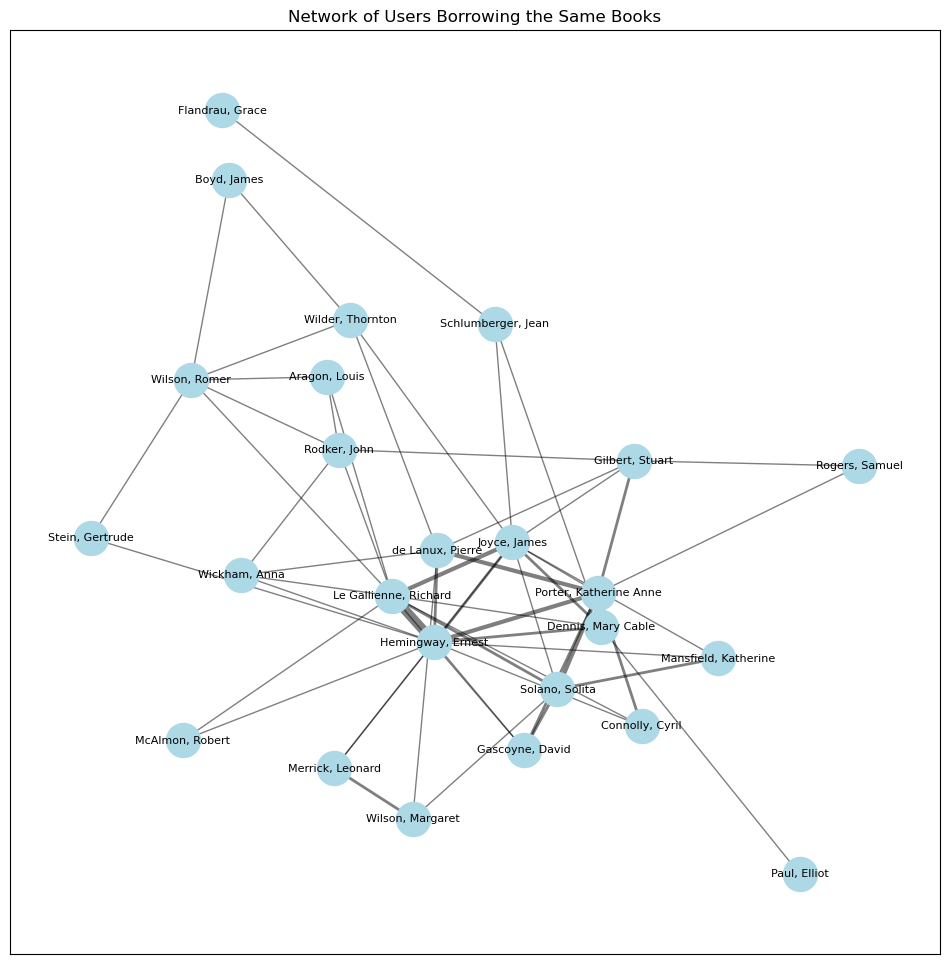

In [178]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(L, seed=42, k=0.2, iterations=25)  # Positions for all nodes
nx.draw_networkx_nodes(L, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(L, pos, width=[L[u][v]['weight'] for u,v in L.edges()], alpha=0.5)
nx.draw_networkx_labels(L, pos, font_size=8)
plt.title('Network of Users Borrowing the Same Books')
plt.show()

The graph maps author-members that borrowed the same books as other author-members. There are clear clusters of datapoints. Richard La Galliene ad Ernest Hemingway borrowed many of the same nodes as the nodes between these two datapoints are the thickest. Surrounding these two nodes, there are others that are also closely connected (James Joyce, Katherine Anne Porter, Pierre de Lanux, and others). Some author-member nodes are more distant to such clusters of nodes, like Elliot Paul and Grace Flandrau who are only connected to one other node each.

In the following, weight is calculated. Weight describes the frequency of the similarities. If member A and member B both borrowed the same books by James Joyce, the weight will be 2.

In [179]:
edge_weights = nx.get_edge_attributes(L,'weight')

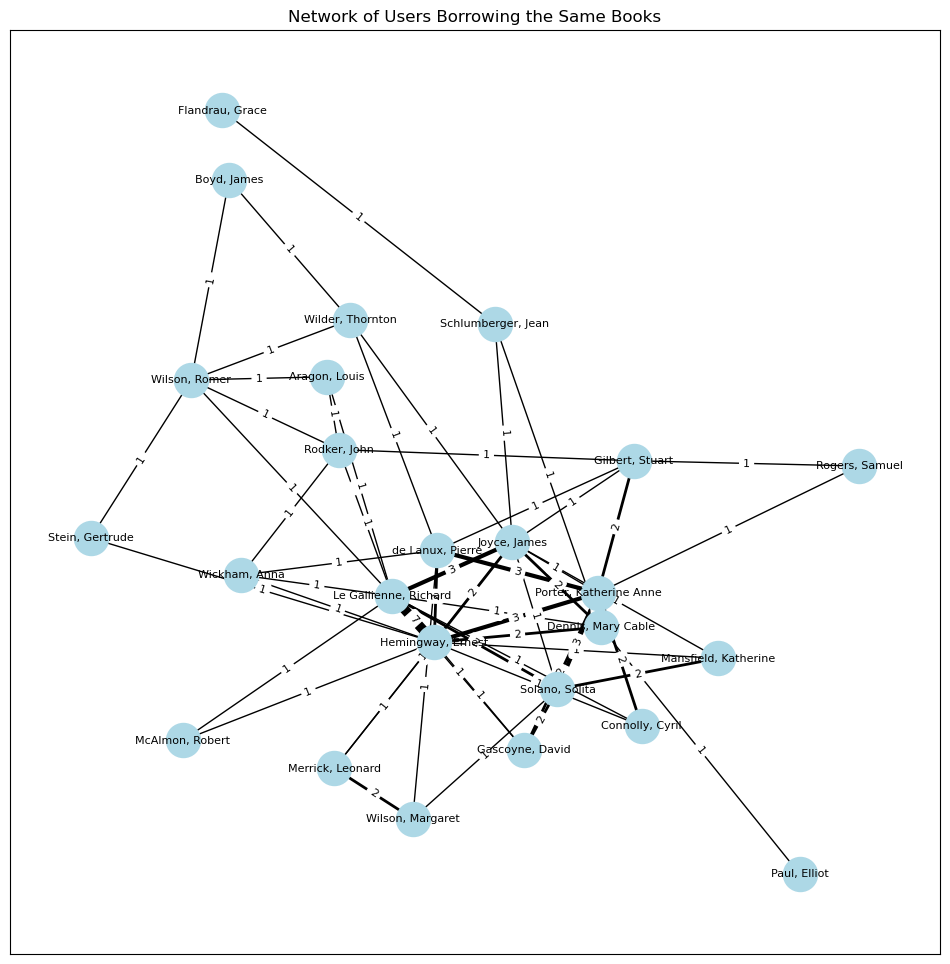

In [180]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(L, seed=42, k=0.2, iterations=25)  # Positions for all nodes
nx.draw_networkx_nodes(L, pos, node_size=600, node_color='lightblue')
nx.draw_networkx_edges(L, pos, width=list(edge_weights.values()))
nx.draw_networkx_edge_labels(L, pos,edge_labels=edge_weights, font_size=8)
nx.draw_networkx_labels(L, pos, font_size=8)
plt.title('Network of Users Borrowing the Same Books')
plt.show()

#### Neighbors

In [181]:
# neighbors of Hemingway, Ernest
list(nx.neighbors(L,'Hemingway, Ernest'))

['Connolly, Cyril',
 'Dennis, Mary Cable',
 'Gascoyne, David',
 'Joyce, James',
 'Le Gallienne, Richard',
 'Mansfield, Katherine',
 'McAlmon, Robert',
 'Merrick, Leonard',
 'Porter, Katherine Anne',
 'Stein, Gertrude',
 'Wickham, Anna',
 'de Lanux, Pierre']

In [182]:
# neighbors of Joyce, James
list(nx.neighbors(L,'Joyce, James'))

['Dennis, Mary Cable',
 'Gilbert, Stuart',
 'Hemingway, Ernest',
 'Le Gallienne, Richard',
 'Mansfield, Katherine',
 'Merrick, Leonard',
 'Porter, Katherine Anne',
 'Schlumberger, Jean',
 'Solano, Solita',
 'Wilder, Thornton']

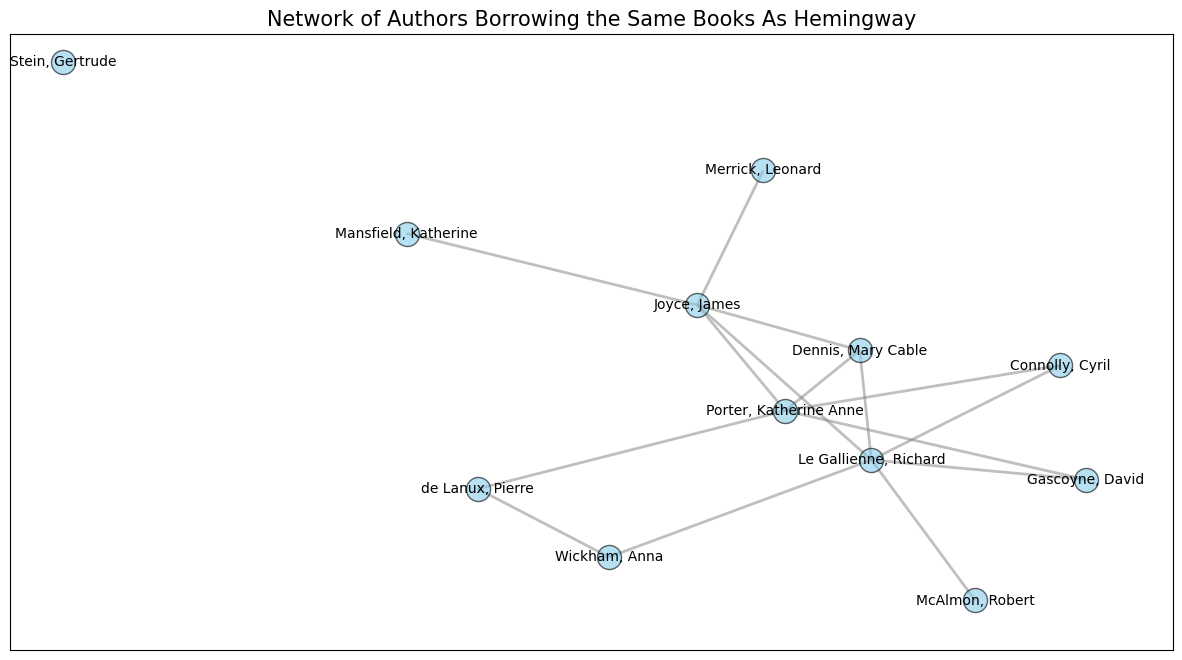

In [183]:
# Create subgraph of Hemingway's neighbors
hemingway_neighbors=nx.subgraph(L,list(nx.neighbors(L,'Hemingway, Ernest')))

dict(hemingway_neighbors.degree(weight='weight'))

# Visualization
plt.figure(figsize=(15, 8))

# Using the Kamada-Kawai layout
pos = nx.spring_layout(hemingway_neighbors, weight=None, seed=42, k=0.6)

# Drawing the nodes
nx.draw_networkx_nodes(hemingway_neighbors, pos, node_size=300, node_color='skyblue', alpha=0.6, edgecolors='black')

# Drawing the edges
nx.draw_networkx_edges(hemingway_neighbors, pos, width=2, alpha=0.5, edge_color='gray')

# Drawing the labels
nx.draw_networkx_labels(hemingway_neighbors, pos, font_size=10, font_color='black')

# Add a title
plt.title('Network of Authors Borrowing the Same Books As Hemingway', size=15)

# Show plot
plt.show()

Only Getrude Stein does not have any connections to author-members within Hemingway's network, which is why no edges connect her to the other nodes. In contrast to Stein, the nodes representing Richard Le Gallienne, Katherine Anne Porter, and James Joyce are more closely connected.

#### Clustering Coefficient

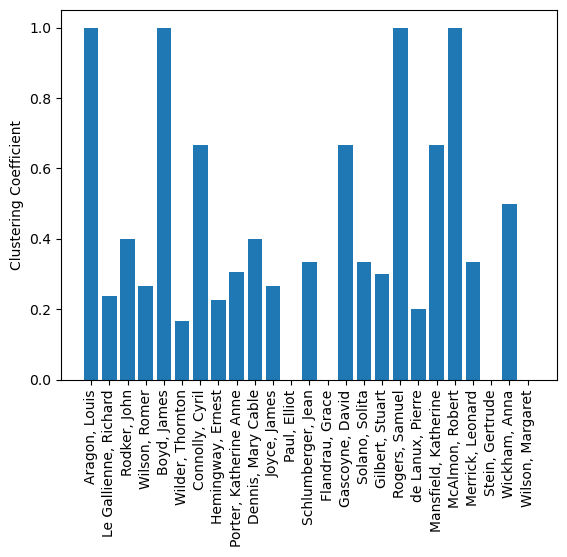

In [184]:
cluster_coeff=nx.clustering(L)
plt.bar(range(len(cluster_coeff)), list(cluster_coeff.values()), align='center')
plt.xticks(range(len(cluster_coeff)), list(cluster_coeff.keys()))
plt.xticks(rotation=90)
plt.ylabel('Clustering Coefficient')
plt.show()

### Nodes, Edges, Diameter, Density, Average Shortest Path Length

In [185]:
# number of nodes
# number of members
len(L.nodes())

25

In [186]:
# number of edges
# number of relationships
len(L.edges())

58

The density of a graph is a measure of how many ties between actors exist compared to how many ties between actors are possible.

In [187]:
# density
nx.density(L)

0.19333333333333333

How many possible edges in the network are present? About 19% --> Relatively diverse reading habits

In [188]:
# diameter
nx.diameter(L)

4

Even in the relatively sparse network, members are not too distant from each other, meaning the library community is fairly interconnected.

In [189]:
# average shortest path length
nx.average_shortest_path_length(L)

2.1733333333333333

Any two nodes in the network can be connected by a little over two steps

#### Assortativity and Average Clustering Coefficient

In [190]:
# assortativity
nx.assortativity.degree_assortativity_coefficient(L)

-0.22988687187582266

Moderately disassortative network: Networks tend to cluster together. It ranges from 0 to 1, where higher values indicate more clustering

In [191]:
# Average clustering coefficient
nx.average_clustering(L)

0.4107676767676767

#### Small World

In [192]:
# Small worldness is defined as the ratio between average clustering coefficient and average shortest path length,
# Relative to an equivalent random graph
print(nx.average_clustering(L)/nx.average_shortest_path_length(L))

0.18900353225506597


In [193]:
nx.algorithms.smallworld.sigma(L,niter=10,nrand=5)

1.0787795067647177

A sigma value greater than 1 indicates that the network exhibits small-world properties. The given network has higher clustering than a random network but similar path lengths, characteristic of small-world networks.

#### Cliques

All nodes in a clique are connected with each other.

Interesting are “maximal cliques”

In [194]:
clique=list(nx.clique.find_cliques(L))

In [195]:
len(clique)

34

In [196]:
clique

[['Aragon, Louis', 'Rodker, John', 'Le Gallienne, Richard', 'Wilson, Romer'],
 ['Schlumberger, Jean', 'Flandrau, Grace'],
 ['Schlumberger, Jean', 'Joyce, James', 'Dennis, Mary Cable'],
 ['Wilson, Romer', 'Wilder, Thornton', 'Boyd, James'],
 ['Wilson, Romer', 'Stein, Gertrude'],
 ['Hemingway, Ernest', 'Porter, Katherine Anne', 'Connolly, Cyril'],
 ['Hemingway, Ernest', 'Porter, Katherine Anne', 'de Lanux, Pierre'],
 ['Hemingway, Ernest',
  'Porter, Katherine Anne',
  'Joyce, James',
  'Dennis, Mary Cable'],
 ['Hemingway, Ernest', 'Porter, Katherine Anne', 'Gascoyne, David'],
 ['Hemingway, Ernest', 'Le Gallienne, Richard', 'Connolly, Cyril'],
 ['Hemingway, Ernest', 'Le Gallienne, Richard', 'Wickham, Anna'],
 ['Hemingway, Ernest', 'Le Gallienne, Richard', 'Gascoyne, David'],
 ['Hemingway, Ernest',
  'Le Gallienne, Richard',
  'Joyce, James',
  'Dennis, Mary Cable'],
 ['Hemingway, Ernest', 'Le Gallienne, Richard', 'McAlmon, Robert'],
 ['Hemingway, Ernest', 'de Lanux, Pierre', 'Wickham, Ann

#### Communities

“there are more links within a community than to nodes
outside of it”

label_propagation_communities generates community sets determined by label propagation

In [197]:
communities=list(nx.community.label_propagation_communities(L))
communities

[{'Aragon, Louis',
  'Connolly, Cyril',
  'Dennis, Mary Cable',
  'Flandrau, Grace',
  'Gascoyne, David',
  'Gilbert, Stuart',
  'Hemingway, Ernest',
  'Joyce, James',
  'Le Gallienne, Richard',
  'Mansfield, Katherine',
  'McAlmon, Robert',
  'Merrick, Leonard',
  'Paul, Elliot',
  'Porter, Katherine Anne',
  'Rodker, John',
  'Rogers, Samuel',
  'Schlumberger, Jean',
  'Solano, Solita',
  'Wickham, Anna',
  'Wilson, Margaret',
  'de Lanux, Pierre'},
 {'Boyd, James', 'Stein, Gertrude', 'Wilder, Thornton', 'Wilson, Romer'}]

In [198]:
node_color_number=[]
for node in L:
    for community in range(len(communities)):
        if str(node) in communities[community]:
            node_color_number.append(community)

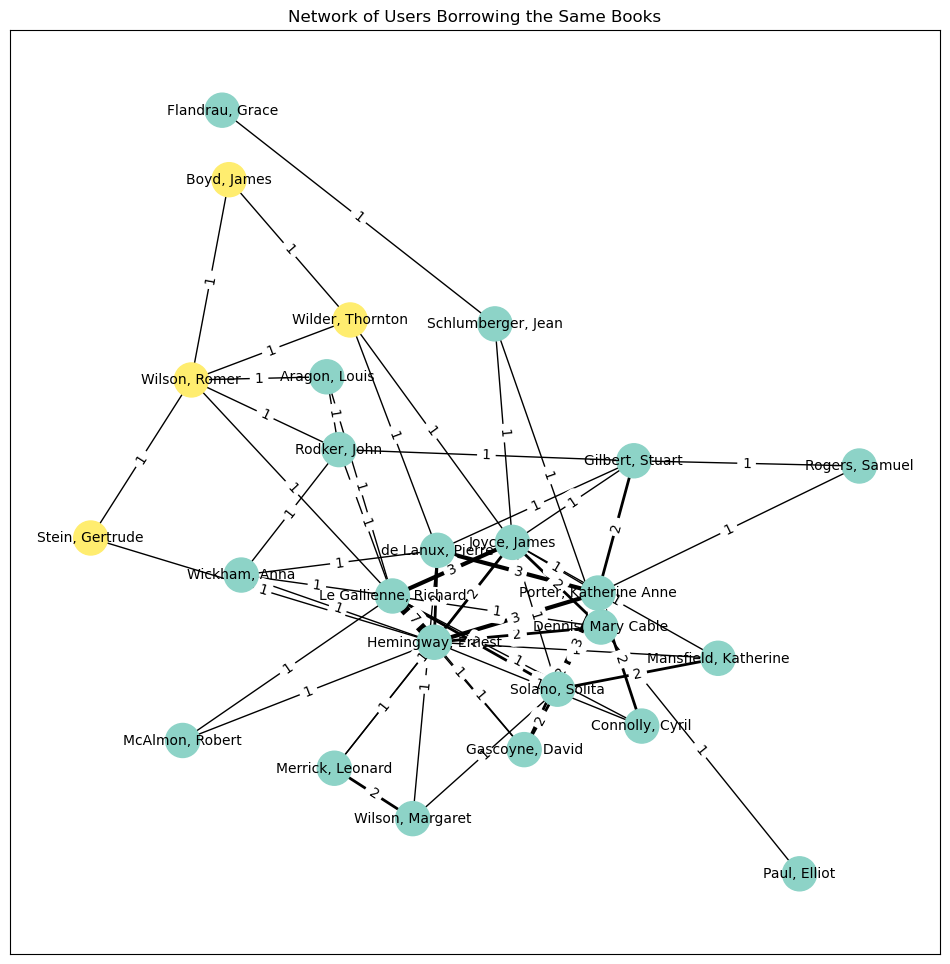

In [199]:
# Create a figure with a specified size
plt.figure(figsize=(12, 12))

# Generate positions for each node using the spring layout
pos = nx.spring_layout(L, seed=42, k=0.2, iterations=25)

# Draw nodes with a color map
nx.draw_networkx_nodes(L, pos, node_size=600, node_color=node_color_number, cmap=plt.cm.Set3)

# Draw edges and edge labels with specified widths
edge_weights = nx.get_edge_attributes(L, 'weight')  # Ensure edge weights are obtained correctly
nx.draw_networkx_edges(L, pos, width=list(edge_weights.values()))
nx.draw_networkx_edge_labels(L, pos, edge_labels=edge_weights)

# Draw node labels
nx.draw_networkx_labels(L, pos, font_size=10, font_family='sans-serif')

# Set the title of the plot
plt.title('Network of Users Borrowing the Same Books')

# Display the plot
plt.show()

This algorithm divided the nodes in only two clusters. One including Gertrude Stein, Romer Wilson, Thornton Wilder, and James Boyd. The other cluster includes all other nodes.

##### Louvain

In [200]:
communities_louvain = list(nx.community.louvain_communities(L, seed=42))
communities_louvain

[{'Hemingway, Ernest',
  'Le Gallienne, Richard',
  'McAlmon, Robert',
  'Wickham, Anna'},
 {'Dennis, Mary Cable',
  'Flandrau, Grace',
  'Joyce, James',
  'Paul, Elliot',
  'Schlumberger, Jean'},
 {'Aragon, Louis',
  'Boyd, James',
  'Rodker, John',
  'Stein, Gertrude',
  'Wilder, Thornton',
  'Wilson, Romer'},
 {'Connolly, Cyril',
  'Gilbert, Stuart',
  'Porter, Katherine Anne',
  'Rogers, Samuel',
  'de Lanux, Pierre'},
 {'Gascoyne, David', 'Mansfield, Katherine', 'Solano, Solita'},
 {'Merrick, Leonard', 'Wilson, Margaret'}]

In [201]:
node_color_number_louvain=[]
for node in L:
    for community in range(len(communities_louvain)):
        if str(node) in communities_louvain[community]:
            node_color_number_louvain.append(community)

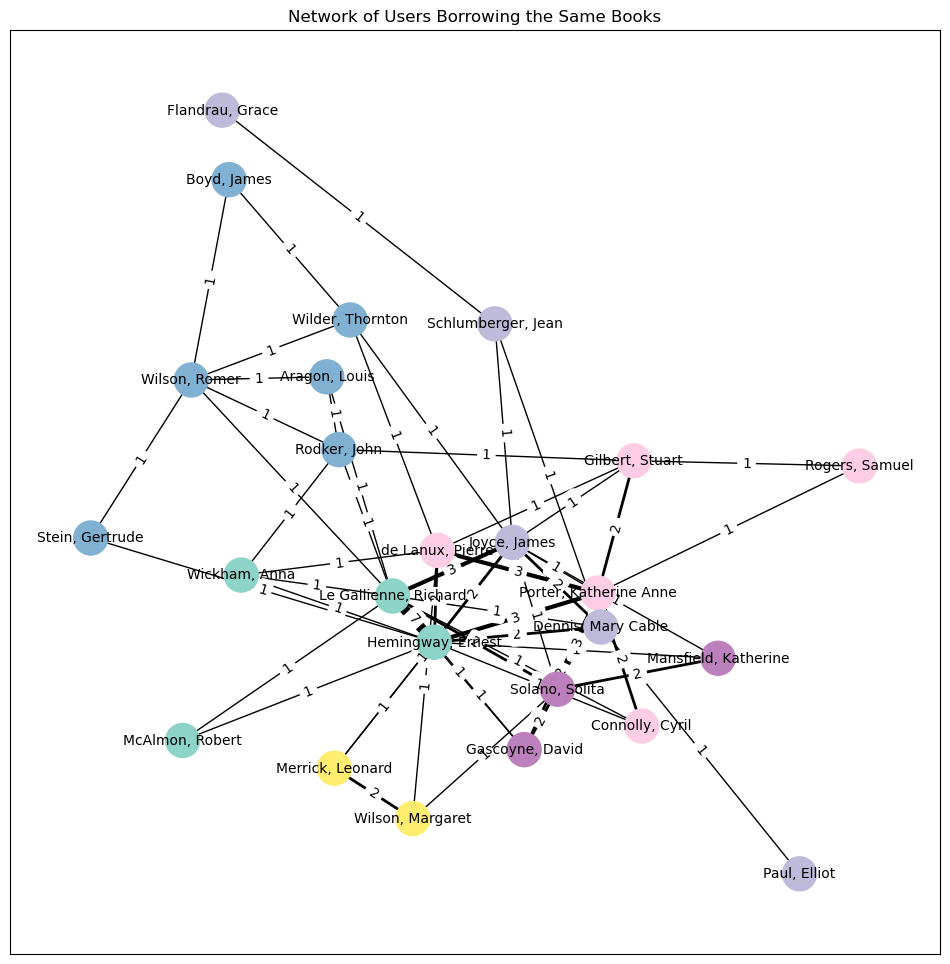

In [202]:
# Create a figure with a specified size
plt.figure(figsize=(12, 12))

# Generate positions for each node using the spring layout
pos = nx.spring_layout(L, seed=42, k=0.2, iterations=25)

# Draw nodes with a color map
nx.draw_networkx_nodes(L, pos, node_size=600, node_color=node_color_number_louvain, cmap=plt.cm.Set3)

# Draw edges and edge labels with specified widths
edge_weights = nx.get_edge_attributes(L, 'weight')  # Ensure edge weights are obtained correctly
nx.draw_networkx_edges(L, pos, width=list(edge_weights.values()))
nx.draw_networkx_edge_labels(L, pos, edge_labels=edge_weights)

# Draw node labels
nx.draw_networkx_labels(L, pos, font_size=10, font_family='sans-serif')

# Set the title of the plot
plt.title('Network of Users Borrowing the Same Books')

# Display the plot
plt.show()

This algorithm found six clusters. It expanded the smaller cluster found by the previous algorithm by including John Rodker and Louis Aragon. Interestingly, this algorithm combines Paul Elliot and Grace Flandrau (the two nodes with the least edges) into the same cluster. It furthermore divides the nodes marked by more frequent edges, such as Hemingway, Joyce, Porter into different clusters.

## Summary and Findings

This exploratory data analysis provided insights into Sylvia Beach's Shakespeare and Company's lending library, focusing on author-members and their books. Only the key findings are highlighted due to the extensive data.

### Geographical Analysis

By narrowing down to members whose books were available, I could map the addresses of author-members. Using non-topological formats (world.shp and world.shx) for storing geometric locations worked well. I also found some author-members lived at the same address at different times, even though the data doesn't specify when.

### Demographic Analysis

I analyzed the gender and age distributions of author-members, giving an idea of the demographics of the author-members.

### Availability of Books

I looked at how many books each author-member had available in the bookstore. This helps understand the presence and influence of different authors in the library.

### Network Analysis

I created network graphs to show similar borrowing behaviors among author-members. Various metrics were calculated, like the clustering coefficient, diameter, cliques, and average shortest path. Different clustering algorithms showed how results can vary.

### Future Directions and Hypotheses

Future analysis could map the borrowing behavior of author-members focusing only on books by other members. This would give clearer insights into what author-members read from each other. I am working on this idea at the moment, but it is not included in this notebook.
It is easy to test the hypothesis as the books need to be merely filtered by authors who are in the author-member list. Work in progress can be accessed at: https://github.com/dittm/shakespeare-and-co/blob/main/analysis_updated/member_is_author_edit.ipynb